# Imports

In [ ]:
# !pip install torch
# !pip install nibabel
# !pip PIL
# !pip install numpy
# !pip install torchio

In [ ]:
import nibabel as nb
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import sys
from tqdm import tqdm
import torch
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.model_selection import train_test_split
import math
import pickle

# Access the data

In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd "/content/drive/MyDrive/Publications and Researches/Multi-Disease, Multi-View & Multi-Center Right Ventricular Segmentation in Cardiac MRI/updated data"

/content/drive/MyDrive/Publications and Researches/Multi-Disease, Multi-View & Multi-Center Right Ventricular Segmentation in Cardiac MRI/updated data


## Training

In [ ]:
images = np.load('MnM2/training/LA/images.npy')
masks = np.load('MnM2/training/LA/masks.npy')

## Testing

In [ ]:
images_testing = np.load('MnM2/testing/LA/images.npy')
masks_testing = np.load('MnM2/testing/LA/masks.npy')

## Validation

In [ ]:
images_validation = np.load('MnM2/validation/LA/images.npy')
masks_validation = np.load('MnM2/validation/LA/masks.npy')

# Transforms

In [ ]:
def replace_tensor_value_(tensor):
    return tensor

input_transform = transforms.Compose(
    [
        transforms.ToTensor()
    ]
)

targets_transform = transforms.Compose(
    [
        transforms.ToTensor()
    ]
)

# Hyperparams

In [ ]:
import torch

learning_rate = 0.0001
batch_size = 4
num_epochs = 200

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('The current processor is ...', device)

The current processor is ... cuda


# Data Loaders

In [ ]:
class MyDataset(Dataset):
  def __init__(self, data, targets, transform=None, target_transform=None):
    self.data = data
    self.targets = targets

    self.transform = transform
    self.target_transform = target_transform

  def __getitem__(self, index):
    x = self.data[index]
    y = self.targets[index]

    if self.transform:
      x = self.data[index]
      x = self.transform(x)

    if self.target_transform:
      y = self.targets[index]
      y = self.target_transform(y)

    return x, y

  def __len__(self):
    return len(self.data)

train_dataset = MyDataset(images, masks, transform=input_transform, target_transform=targets_transform)

# del images
# del masks

test_dataset = MyDataset(images_testing, masks_testing, transform=input_transform, target_transform=targets_transform)

# del images_testing
# del masks_testing

val_dataset = MyDataset(images_validation, masks_validation, transform=input_transform, target_transform=targets_transform)

# del images_validation
# del masks_validation

train_loader = DataLoader(train_dataset, batch_size=batch_size)
del train_dataset

test_loader = DataLoader(test_dataset, batch_size=batch_size)
del test_dataset

val_loader = DataLoader(val_dataset, batch_size=batch_size)
del val_dataset

In [ ]:
inputs, classes = next(iter(train_loader))
inputs.shape, inputs.min(), inputs.max(), classes.shape, classes.min(), classes.max()

(torch.Size([4, 1, 240, 240]),
 tensor(0., dtype=torch.float64),
 tensor(7642.1944, dtype=torch.float64),
 torch.Size([4, 1, 240, 240]),
 tensor(0., dtype=torch.float64),
 tensor(3., dtype=torch.float64))

# Plot Image

In [ ]:
from skimage.transform import resize

def plot_images(img, mask):
  print("img " , img.shape)
  print("mask ", mask.shape)

  viz_dict = {"Image/pred": img, "Segmentation Map": mask}

  fig = plt.figure(figsize=(15, 15))

  count = 2

  for i, j in viz_dict.items():
    ax = plt.subplot(1, 3, count)
    plt.imshow(j)
    plt.title(i)
    plt.axis("on")
    count += 1

def plot_images_by_path(dir, train_or_test, la_or_sa, ed_or_es, id):
  img = nb.load(dir+train_or_test+"/"+id+"/"+id+"_"+la_or_sa+"_"+ed_or_es+".nii.gz").get_fdata()
  mask = nb.load(dir+train_or_test+"/"+id+"/"+id+"_"+la_or_sa+"_"+ed_or_es+"_gt.nii.gz").get_fdata()

  plot_images(img, mask)

img  torch.Size([240, 240])
mask  torch.Size([240, 240])


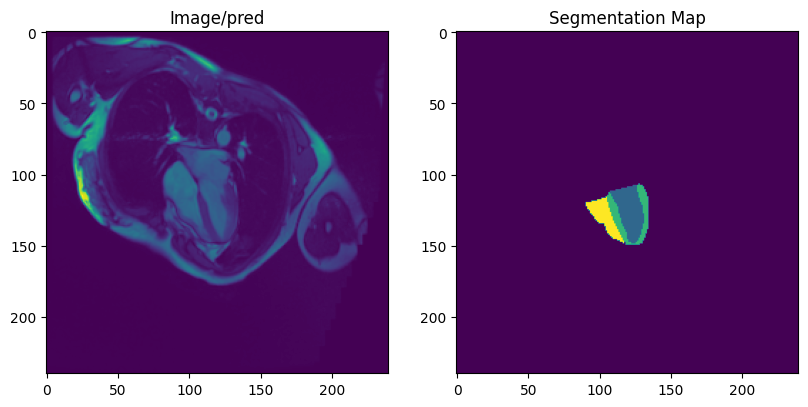

In [ ]:
plot_images(inputs[0].squeeze(0), classes[0].squeeze(0))

# Loss Function

## Dice Score

In [ ]:
import torch
from torch import Tensor

def dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon=1e-6):
    # Average of Dice coefficient for all batches, or for a single mask
    assert input.size() == target.size()
    if input.dim() == 2 and reduce_batch_first:
        raise ValueError(f'Dice: asked to reduce batch but got tensor without batch dimension (shape {input.shape})')

    if input.dim() == 2 or reduce_batch_first:
        inter = torch.dot(input.reshape(-1), target.reshape(-1))
        sets_sum = torch.sum(input) + torch.sum(target)
        if sets_sum.item() == 0:
            sets_sum = 2 * inter

        return (2 * inter + epsilon) / (sets_sum + epsilon)
    else:
        # compute and average metric for each batch element
        dice = 0
        for i in range(input.shape[0]):
            dice += dice_coeff(input[i, ...], target[i, ...])
        return dice / input.shape[0]


def multiclass_dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon=1e-6):
    # Average of Dice coefficient for all classes
    assert input.size() == target.size()
    dice = 0
    for channel in range(input.shape[1]):
        dice += dice_coeff(input[:, channel, ...], target[:, channel, ...], reduce_batch_first, epsilon)

    return dice / input.shape[1]


def dice_loss(input: Tensor, target: Tensor, multiclass: bool = False):
    # Dice loss (objective to minimize) between 0 and 1
    assert input.size() == target.size()
    fn = multiclass_dice_coeff if multiclass else dice_coeff
    return 1 - fn(input, target, reduce_batch_first=True)

## Hausdorff distance

In [ ]:
def hausdorff_distance(tensor1, tensor2):
    # Reshape tensors to [batch_size, x] where x is flattened
    tensor1_flat = tensor1.reshape(2, -1)
    tensor2_flat = tensor2.reshape(2, -1)

    # Calculate pairwise Euclidean distance between all points
    distances = torch.cdist(tensor1_flat, tensor2_flat)

    # Find shortest distance from tensor1 to tensor2
    shortest_distance_1to2, _ = torch.min(distances, dim=1)

    # Find shortest distance from tensor2 to tensor1
    shortest_distance_2to1, _ = torch.min(distances, dim=0)

    # Hausdorff Distance is the maximum of the shortest distances
    hausdorff_distance = torch.max(shortest_distance_1to2.max(), shortest_distance_2to1.max())

    return hausdorff_distance

def hd_loss(mask_pred, mask_true):
    num_classes = mask_pred.size(1)  # Number of classes
    batch_size = mask_pred.size(0)   # Batch size

    hd_loss_per_class = []

    for class_idx in range(num_classes):
        hd_per_class = 0.0
        for batch_idx in range(batch_size):
            # Calculate HD for a single class in a single image
            dist = hausdorff_distance(mask_pred[batch_idx, class_idx].cpu(), mask_true[batch_idx, class_idx].cpu())
            hd_per_class += dist

        # Average HD for this class across the batch
        hd_loss_per_class.append(hd_per_class / batch_size)

    # Compute the average HD loss across all classes
    loss = torch.mean(torch.stack(hd_loss_per_class))

    return loss

# UNet Model

Vanila U-NET + PReLU + ResBlocks + Dropout

In [ ]:
import torch
import torch.nn as nn
import math

class PositionalEncoding(nn.Module):
    """
    Implements a simple positional encoding for 2D feature maps.
    """
    def __init__(self, channels, height, width):
        super(PositionalEncoding, self).__init__()
        self.channels = channels
        self.positional_encoding = nn.Parameter(torch.zeros(1, channels, height, width), requires_grad=True)
        nn.init.uniform_(self.positional_encoding, -0.1, 0.1)

    def forward(self, x):
        return x + self.positional_encoding

class AttentionBlock(nn.Module):
    """
    An attention block that applies multi-head self-attention over the input feature map.
    """
    def __init__(self, in_channels, height, width, heads=4):
        super(AttentionBlock, self).__init__()
        self.height = height
        self.width = width

        self.pos_encoding = PositionalEncoding(in_channels, height, width)
        self.attention = nn.MultiheadAttention(in_channels, num_heads=heads, batch_first=True)

    def forward(self, x):
        x = self.pos_encoding(x)
        x = x.flatten(2).permute(0, 2, 1)
        attn_output, _ = self.attention(x, x, x)
        attn_output = attn_output.permute(0, 2, 1).view(x.size(0), -1, self.height, self.width)
        return attn_output

class ResidualBlock(nn.Module):
    """
    A basic residual block.
    """
    def __init__(self, in_channels, out_channels, dropout_rate=0.5):
        super(ResidualBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.PReLU(),
            nn.Dropout(dropout_rate),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        self.relu = nn.PReLU()

        # If in_channels != out_channels, adjust dimensions with a 1x1 conv
        if in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.downsample = None

    def forward(self, x):
        identity = x

        out = self.conv(x)

        if self.downsample is not None:
            identity = self.downsample(identity)

        out += identity
        out = self.relu(out)

        return out

class UNet2D(nn.Module):
    """
    U-Net 2D architecture with integrated multi-head self-attention, positional encoding in encoder blocks, and residual connections.
    """
    def __init__(self, in_channels, out_channels, dropout_rate=0.5):
        super(UNet2D, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.dropout_rate = dropout_rate

        # Modify encoder and decoder blocks to use ResidualBlock
        self.encoder1 = ResidualBlock(in_channels, 64, dropout_rate)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = ResidualBlock(64, 128, dropout_rate)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = ResidualBlock(128, 256, dropout_rate)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = ResidualBlock(256, 512, dropout_rate)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Middle block remains the same
        self.middle = ResidualBlock(512, 1024, dropout_rate)
                                    # AttentionBlock(1024, 15, 15))

        # Decoder blocks, now using ResidualBlock
        self.up1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.decoder1 = ResidualBlock(1024, 512, dropout_rate)
        self.up2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder2 = ResidualBlock(512, 256, dropout_rate)
        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder3 = ResidualBlock(256, 128, dropout_rate)
        self.up4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder4 = ResidualBlock(128, 64, dropout_rate)

        # Output block remains the same
        self.out_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
      # print(x.shape)

        # print('------')

        # Encoder
        enc1 = self.encoder1(x)
        # print(enc1.shape)
        enc1_pool = self.pool1(enc1)
        # print(enc1_pool.shape)

        # print('------')

        enc2 = self.encoder2(enc1_pool)
        # print(enc2.shape)
        enc2_pool = self.pool2(enc2)
        # print(enc2_pool.shape)

        # print('------')

        enc3 = self.encoder3(enc2_pool)
        # print(enc3.shape)
        enc3_pool = self.pool3(enc3)
        # print(enc3_pool.shape)

        # print('------')

        enc4 = self.encoder4(enc3_pool)
        # print(enc4.shape)
        enc4_pool = self.pool4(enc4)
        # print(enc4_pool.shape)

        # print('------')

        # Middle
        middle = self.middle(enc4_pool)
        # print(middle.shape)

        # print('------')

        # Decoder
        dec1 = self.up1(middle)
        # print(dec1.shape)
        dec1 = torch.cat([dec1, enc4], dim=1)
        dec1 = self.decoder1(dec1)
        # print(dec1.shape)

        # print('-------')

        dec2 = self.up2(dec1)
        # print(dec2.shape)
        dec2 = torch.cat([dec2, enc3], dim=1)
        dec2 = self.decoder2(dec2)
        # print(dec2.shape)

        # print('-------')

        dec3 = self.up3(dec2)
        # print(dec3.shape)
        dec3 = torch.cat([dec3, enc2], dim=1)
        dec3 = self.decoder3(dec3)
        # print(dec3.shape)

        # print('-------')

        dec4 = self.up4(dec3)
        # print(dec4.shape)
        dec4 = torch.cat([dec4, enc1], dim=1)
        # print(dec4.shape)
        dec4 = self.decoder4(dec4)
        # print(dec4.shape)

        # print('-------')

        # Output
        output = self.out_conv(dec4)
        # print(output.shape)
        return output

U-NET with ViT + ResBlocks + PReLU + Dropout

In [ ]:
import torch
import torch.nn as nn
import math

class PositionalEncoding(nn.Module):
    def __init__(self, channels, height, width):
        super(PositionalEncoding, self).__init__()
        self.channels = channels
        self.positional_encoding = nn.Parameter(torch.zeros(1, channels, height, width), requires_grad=True)
        nn.init.uniform_(self.positional_encoding, -0.1, 0.1)

    def forward(self, x):
        return x + self.positional_encoding

class AttentionBlock(nn.Module):
    def __init__(self, in_channels, heads=1024):
        super(AttentionBlock, self).__init__()

        self.attention = nn.MultiheadAttention(in_channels, num_heads=heads, batch_first=True)

    def forward(self, x):
        b, c, h, w = x.shape  # Dynamically obtain the feature map size
        x = x.flatten(2).permute(0, 2, 1)  # Reshape to (batch_size, sequence_length, embedding_size)
        attn_output, _ = self.attention(x, x, x)
        attn_output = attn_output.permute(0, 2, 1).view(b, c, h, w)  # Reshape back to the original feature map shape
        return attn_output

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_rate=0.5):
        super(ResidualBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.PReLU(),
            nn.Dropout(dropout_rate),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        self.relu = nn.PReLU()

        # If in_channels != out_channels, adjust dimensions with a 1x1 conv
        if in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.downsample = None

    def forward(self, x):
        identity = x

        out = self.conv(x)

        if self.downsample is not None:
            identity = self.downsample(identity)

        out += identity
        out = self.relu(out)

        return out

class UNet2D(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_rate=0.5):
        super(UNet2D, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.dropout_rate = dropout_rate

        # Modify encoder and decoder blocks to use ResidualBlock
        self.encoder1 = ResidualBlock(in_channels, 64, dropout_rate)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.encoder2 = ResidualBlock(64, 128, dropout_rate)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.encoder3 = ResidualBlock(128, 256, dropout_rate)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.encoder4 = ResidualBlock(256, 512, dropout_rate)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)


        # Middle block remains the same
        self.middle = nn.Sequential(
            ResidualBlock(512, 1024, dropout_rate),
                                    AttentionBlock(1024))

        # Decoder blocks, now using ResidualBlock
        self.up1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.decoder1 = ResidualBlock(1024, 512, dropout_rate)

        self.up2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder2 = ResidualBlock(512, 256, dropout_rate)

        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder3 = ResidualBlock(256, 128, dropout_rate)

        self.up4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder4 = ResidualBlock(128, 64, dropout_rate)

        # Output block remains the same
        self.out_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        enc1 = self.encoder1(x)
        enc1_pool = self.pool1(enc1)

        enc2 = self.encoder2(enc1_pool)
        enc2_pool = self.pool2(enc2)

        enc3 = self.encoder3(enc2_pool)
        enc3_pool = self.pool3(enc3)

        enc4 = self.encoder4(enc3_pool)
        enc4_pool = self.pool4(enc4)

        # Middle
        middle = self.middle(enc4_pool)

        # Decoder
        dec1 = self.up1(middle)
        dec1 = torch.cat([dec1, enc4], dim=1)
        dec1 = self.decoder1(dec1)

        dec2 = self.up2(dec1)
        dec2 = torch.cat([dec2, enc3], dim=1)
        dec2 = self.decoder2(dec2)

        dec3 = self.up3(dec2)
        dec3 = torch.cat([dec3, enc2], dim=1)
        dec3 = self.decoder3(dec3)

        dec4 = self.up4(dec3)
        dec4 = torch.cat([dec4, enc1], dim=1)
        dec4 = self.decoder4(dec4)

        # Output
        output = self.out_conv(dec4)
        return output

# Training

In [ ]:
in_channels = 1
out_channels = 4
model = UNet2D(in_channels, out_channels).to(device)

In [ ]:
import torch.optim as optim
# from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import CosineAnnealingLR

optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=1e-8, momentum=0.9)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)  # goal: maximize Dice score

scheduler = CosineAnnealingLR(optimizer, T_max=10)
grad_scaler = torch.cuda.amp.GradScaler(enabled=False)
criterion = nn.CrossEntropyLoss()
global_step = 0

# import torch.optim as optim

# optimizer = optim.Adam(model.parameters(), lr=0.0005)
# criterion = nn.CrossEntropyLoss()

In [ ]:
from torchsummary import summary

summary(model,input_size=(1,240,240))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 240, 240]             576
       BatchNorm2d-2         [-1, 64, 240, 240]             128
             PReLU-3         [-1, 64, 240, 240]               1
           Dropout-4         [-1, 64, 240, 240]               0
            Conv2d-5         [-1, 64, 240, 240]          36,864
       BatchNorm2d-6         [-1, 64, 240, 240]             128
            Conv2d-7         [-1, 64, 240, 240]              64
       BatchNorm2d-8         [-1, 64, 240, 240]             128
             PReLU-9         [-1, 64, 240, 240]               1
    ResidualBlock-10         [-1, 64, 240, 240]               0
        MaxPool2d-11         [-1, 64, 120, 120]               0
           Conv2d-12        [-1, 128, 120, 120]          73,728
      BatchNorm2d-13        [-1, 128, 120, 120]             256
            PReLU-14        [-1, 128, 1

## Training Loop

In [ ]:
# training_data = {"Loss_vals":[], "accuracy_vals":[], "hd_vals":[],"lr_decay":[]}
training_data = {"loss":[], "epoch":[],"lr":[], "dice_loss":[], "hd_loss":[], "multiclass_dice_score": []}
model_path = '../final_model/vanila_unet_512/la-batch-size-4-CosineAnnealingLR-prelu-200-epoch-resblock-vit-unet-1024-heads-dropout'
model.train()

UNet2D(
  (encoder1): ResidualBlock(
    (conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): PReLU(num_parameters=1)
      (3): Dropout(p=0.5, inplace=False)
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (relu): PReLU(num_parameters=1)
    (downsample): Sequential(
      (0): Conv2d(1, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): ResidualBlock(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, ep

In [ ]:
import math
min_loss= math.inf

for epoch in range(num_epochs):
  total_loss = 0
  dice_loss_val = 0
  hd_loss_val = 0
  dice_score_val = 0
  for index, (inputs, classes) in enumerate(train_loader):
    #forward pass
    pred_mask = model(inputs.to(dtype=torch.float).to(device))
    pred_mask = F.softmax(pred_mask, dim=1).float()
    pred = np.argmax(pred_mask[0].cpu().detach().numpy(), axis=0)

    #masks
    classes_1 = classes.to(dtype=torch.long).to(device).squeeze(1)
    masks_one_hot = F.one_hot(classes_1, model.out_channels).permute(0, 3, 1, 2).to(dtype=torch.float)
    mask_ohe = np.argmax(masks_one_hot[0].cpu().detach().numpy(), axis=0)

    #loss
    mean_dice_loss = dice_loss(pred_mask,  masks_one_hot, multiclass=True)
    mean_hd_loss = hd_loss(pred_mask,  masks_one_hot)

    lambda_param = (mean_hd_loss/mean_dice_loss) if epoch == 0 else (epoch_hd/epoch_dice_loss)
    loss = lambda_param * mean_dice_loss + mean_hd_loss

    with torch.no_grad():
      dice_score = multiclass_dice_coeff(pred_mask,  masks_one_hot, reduce_batch_first=False)
      total_loss += loss.item()
      dice_loss_val += mean_dice_loss.item()
      hd_loss_val += mean_hd_loss.item()
      dice_score_val += dice_score.item()

    #backward pass
    # optimizer.zero_grad(set_to_none=True)
    # loss.backward()
    # optimizer.step()

    optimizer.zero_grad(set_to_none=True)
    grad_scaler.scale(loss).backward()
    grad_scaler.step(optimizer)
    grad_scaler.update()

  epoch_loss = total_loss / len(train_loader)
  epoch_dice_loss = dice_loss_val / len(train_loader)
  epoch_dice_score = dice_score_val / len(train_loader)
  epoch_hd = hd_loss_val / len(train_loader)

  scheduler.step()

  training_data["loss"].append(epoch_loss)
  training_data["epoch"].append(epoch)
  training_data["lr"].append(optimizer.param_groups[0]['lr'])
  training_data["dice_loss"].append(epoch_dice_loss)
  training_data["hd_loss"].append(epoch_hd)
  training_data["multiclass_dice_score"].append(epoch_dice_score)

  # print("loss: ", epoch_loss, "dice: ", mean_dice_loss.item(), "hd: ", mean_hd_loss.item(), "dice score: ", dice_score.item())
  print("epoch: ", epoch,"loss: ", epoch_loss, "dice_loss: ", epoch_dice_loss, "hd: ", epoch_hd, "dice score: ", epoch_dice_score, "lr", optimizer.param_groups[0]['lr'])


  if epoch_loss < min_loss:
      torch.save(model.state_dict(), f'{model_path}.pt')
      with open(f'{model_path}.pkl', 'wb') as f:
          pickle.dump(training_data, f)

      min_loss = epoch_loss

plot_images(pred, mask_ohe)

epoch:  0 loss:  78.02348461151124 dice_loss:  0.7156625591218472 hd:  39.01174235343933 dice score:  0.28325625471770766 lr 9.755282581475769e-05
epoch:  1 loss:  58.20434050559997 dice_loss:  0.5345707386732101 hd:  29.064160537719726 dice score:  0.46188402101397513 lr 9.045084971874737e-05
epoch:  2 loss:  52.887178087234496 dice_loss:  0.4636870354413986 hd:  27.676904964447022 dice score:  0.5322736162692309 lr 7.938926261462366e-05
epoch:  3 loss:  48.63282933235168 dice_loss:  0.3845106765627861 hd:  25.68186275959015 dice score:  0.609607583656907 lr 6.545084971874737e-05
epoch:  4 loss:  46.22332661151886 dice_loss:  0.3292641952633858 hd:  24.231434059143066 dice score:  0.665569382533431 lr 4.9999999999999996e-05
epoch:  5 loss:  44.460575103759766 dice_loss:  0.2908379971981049 hd:  23.057026731967927 dice score:  0.7028615068644285 lr 3.454915028125263e-05
epoch:  6 loss:  42.93672747612 dice_loss:  0.26287473663687705 hd:  22.096570122241975 dice score:  0.73096298985183

KeyboardInterrupt: 

In [ ]:
with open(f'{model_path}.pkl', 'wb') as f:
  pickle.dump(training_data, f)

## Test the model with one batch

In [ ]:
inputs, classes = next(iter(train_loader))
inputs.shape, inputs.min(), inputs.max(), classes.shape, classes.min(), classes.max()

In [ ]:
#forward p
optimizer.zero_grad()
pred_mask = model(inputs.to(dtype=torch.float).to(device))

In [ ]:
pred_mask = F.softmax(pred_mask, dim=1).float()

In [ ]:
pred_mask.shape

torch.Size([8, 4, 240, 240])

In [ ]:
pred = np.argmax(pred_mask[0].cpu().detach().numpy(), axis=0)
pred.shape

(240, 240)

In [ ]:
classes_1 = classes.to(dtype=torch.long).to(device).squeeze(1)
print('shape of classes_1: ',classes_1.shape)
masks_one_hot = F.one_hot(classes_1, model.out_channels).permute(0, 3, 1, 2).to(dtype=torch.float)
print('shape of masks_one_hot: ',masks_one_hot.shape)

mean_dice_loss = dice_loss(pred_mask,  masks_one_hot, multiclass=True)
mean_hd_loss = hd_loss(pred_mask,  masks_one_hot)
lambda_param = (mean_dice_loss/ mean_hd_loss)
loss = mean_dice_loss + lambda_param * mean_hd_loss
print("loss: ", loss.item())

shape of classes_1:  torch.Size([8, 240, 240])
shape of masks_one_hot:  torch.Size([8, 4, 240, 240])
loss:  0.21790611743927002


In [ ]:
mask_ohe = np.argmax(masks_one_hot[0].cpu().detach().numpy(), axis=0)
mask_ohe.shape

(240, 240)

img  (240, 240)
mask  torch.Size([240, 240])


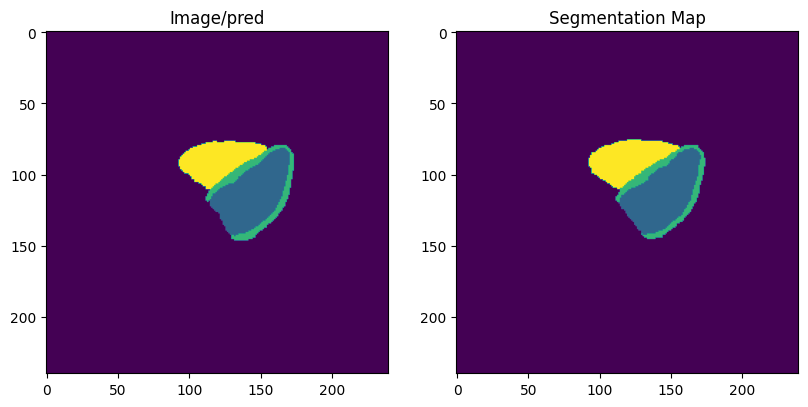

In [ ]:
plot_images(pred,classes_1[0].to(dtype=torch.float).cpu())

img  (240, 240)
mask  (240, 240)


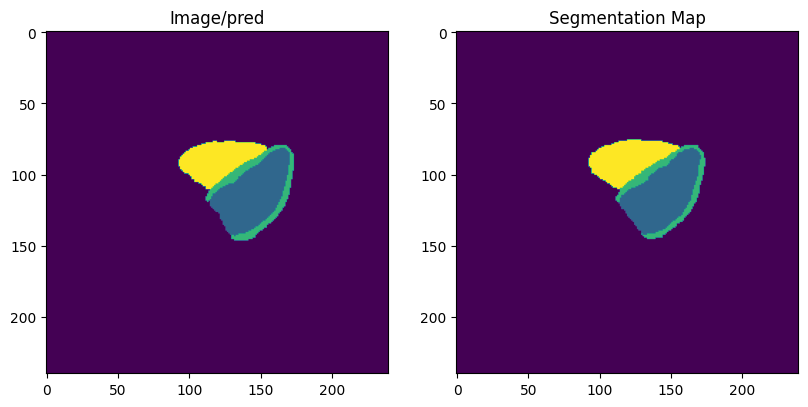

In [ ]:
plot_images(pred,mask_ohe)

In [ ]:
#backward p
optimizer.zero_grad(set_to_none=True)
loss.backward()
optimizer.step()

# Save and Load model

In [ ]:
# Save the model to a file
# torch.save(model.state_dict(), f'{model_path}.pt')
# with open(f'{model_path}.pkl', 'wb') as f:
#     pickle.dump(training_data, f)

model_path = '../final_model/vanila_unet_512/la-batch-size-2-CosineAnnealingLR-prelu-200-epoch-resblock-vit-unet-1024-heads-dropout'

# Later, you can load the model from the file
model = UNet2D(1,4).to(device)
# model.load_state_dict(torch.load(f'{model_path}.pt', map_location=torch.device('cpu')))
model.load_state_dict(torch.load(f'{model_path}.pt'))

with open(f'{model_path}.pkl', 'rb') as filehandle:
    loaded_training_data  = pickle.load(filehandle)

In [ ]:
for i in range(len(loaded_training_data['epoch'])):
  print(f"({loaded_training_data['epoch'][i]}, {loaded_training_data['hd_loss'][i]})")

(0, 30.718063759803773)
(1, 25.225033819675446)
(2, 24.859479129314423)
(3, 23.205757838487624)
(4, 21.71829320192337)
(5, 20.510554760694504)
(6, 19.283260864019393)
(7, 18.46904355287552)
(8, 18.082077836990358)
(9, 18.12014382481575)
(10, 18.22095904350281)
(11, 17.853564429283143)
(12, 17.285130602121352)
(13, 17.23639971613884)
(14, 17.261053985357286)
(15, 17.314484077692033)
(16, 17.82694630622864)
(17, 17.52293866276741)
(18, 17.92108589410782)
(19, 17.342494946718215)
(20, 17.015551537275314)
(21, 16.577977496385575)
(22, 16.111692929267882)
(23, 15.674936485290527)
(24, 15.071425127983094)
(25, 14.546669429540634)
(26, 14.107692062854767)
(27, 13.650098705291748)
(28, 13.374638706445694)
(29, 13.617577755451203)
(30, 13.45562539100647)
(31, 13.317666232585907)
(32, 13.013109654188156)
(33, 12.872021776437759)
(34, 13.018776693940163)
(35, 13.20168490409851)
(36, 13.370114839076995)
(37, 13.330408445000648)
(38, 13.746810114383697)
(39, 14.414853948354722)
(40, 13.798474210500

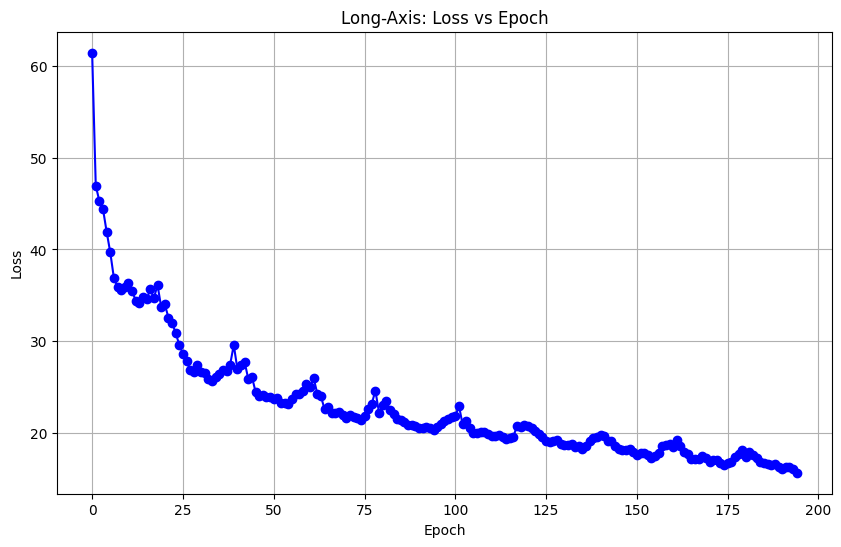

In [ ]:
import matplotlib.pyplot as plt

epoch = loaded_training_data['epoch']
loss = loaded_training_data['loss']
dice_loss = loaded_training_data['dice_loss']
hd_loss = loaded_training_data['hd_loss']

# plot epoch vs loss
plt.figure(figsize=(10, 6))
plt.plot(epoch, loss, marker='o', linestyle='-', color='b')
plt.title('Long-Axis: Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


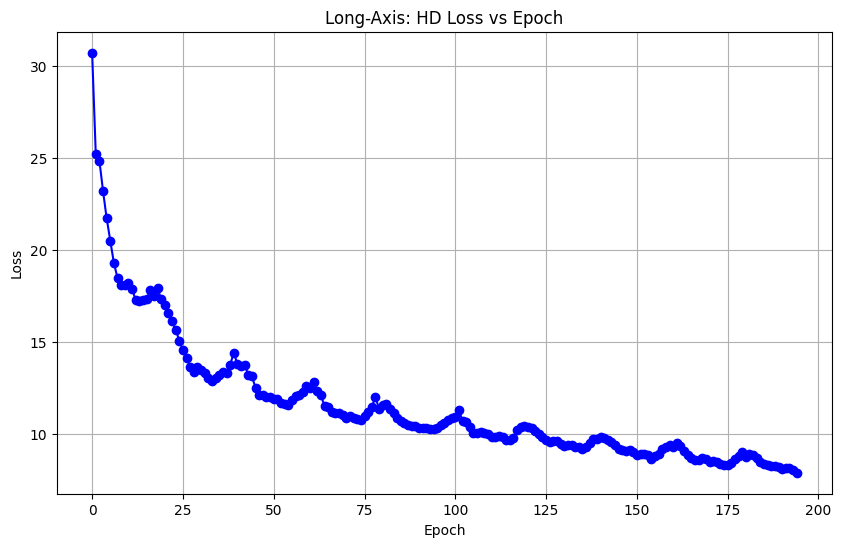

In [ ]:
# plot epoch vs hd loss
plt.figure(figsize=(10, 6))
plt.plot(epoch, hd_loss, marker='o', linestyle='-', color='b')
plt.title('Long-Axis: HD Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


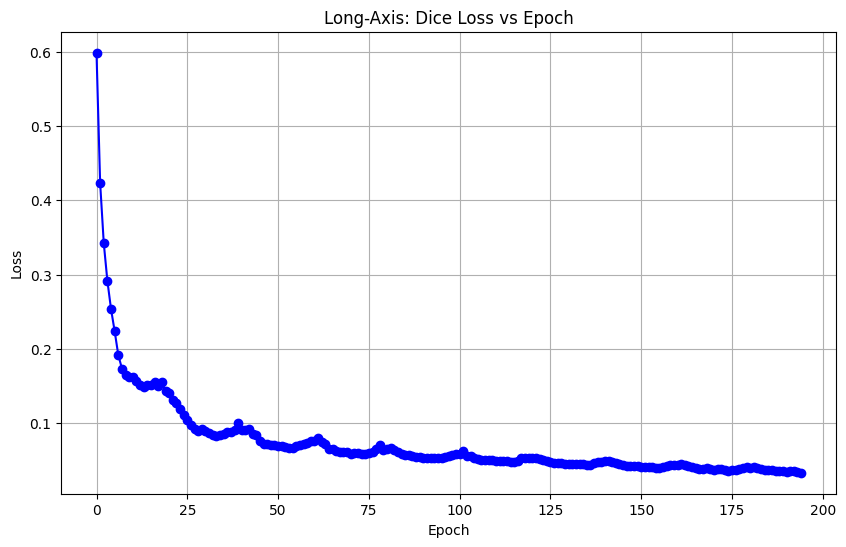

In [ ]:
# plot epoch vs dice loss
plt.figure(figsize=(10, 6))
plt.plot(epoch, dice_loss, marker='o', linestyle='-', color='b')
plt.title('Long-Axis: Dice Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# Evaluate

In [ ]:
def evaluation_hd(net, dataloader, device):
    num_val_batches = len(dataloader)
    num_classes = net.out_channels  # Number of classes
    hd_loss_per_class = [0.0] * num_classes  # Initialize HD loss for each class

    # iterate over the validation set
    for ix, (images, true_masks) in enumerate(dataloader):

        # data compartmentalization
        image = images.float().to(device)
        mask_true = true_masks.to(dtype=torch.long).to(device).squeeze(1)

        # One Hot Encode
        mask_true = F.one_hot(mask_true, net.out_channels).float().permute(0, 3, 1, 2)

        with torch.no_grad():
            # predict the mask
            mask_pred = net(image)

            # Convert predictions to labels
            mask_pred = F.softmax(mask_pred, dim=1).float()
            batch_size = mask_pred.size(0)

            for class_idx in range(num_classes):
                hd_per_class = 0.0
                for batch_idx in range(batch_size):
                    # Calculate HD for a single class in a single image
                    dist = hausdorff_distance(mask_pred[batch_idx, class_idx], mask_true[batch_idx, class_idx])
                    hd_per_class += dist

                # Accumulate HD loss for this class
                hd_loss_per_class[class_idx] += hd_per_class/batch_size

    scores = [f"class {i} : {hd_score / num_val_batches}" for i, hd_score in enumerate(hd_loss_per_class)]
    avg_hd_score = torch.mean(torch.stack(hd_loss_per_class)) / num_val_batches
    scores.append(f"average: {avg_hd_score}")

    return scores

In [ ]:
evaluation_hd(model, train_loader, device)

['class 0 : 28.55657386779785',
 'class 1 : 20.291973114013672',
 'class 2 : 18.614574432373047',
 'class 3 : 23.746631622314453',
 'average: 22.802438735961914']

In [ ]:
evaluation_hd(model, val_loader, device)

['class 0 : 30.14606285095215',
 'class 1 : 20.956945419311523',
 'class 2 : 18.707563400268555',
 'class 3 : 25.755855560302734',
 'average: 23.8916072845459']

In [ ]:
evaluation_hd(model, test_loader, device)

['class 0 : 18.987953186035156',
 'class 1 : 13.240196228027344',
 'class 2 : 14.445805549621582',
 'class 3 : 15.756608963012695',
 'average: 15.60764217376709']

In [ ]:
import torch
import torch.nn.functional as F
from tqdm import tqdm

# TODO: See what eval metric they use change accordingly.

def evaluate(net, dataloader, device):
    num_val_batches = len(dataloader)
    dice_scores = [0] * net.out_channels  # Initialize a list to store Dice scores for each class

    # iterate over the validation set
    for ix, (images, true_masks) in enumerate(dataloader):
        # data compartmentalization
        image = images.float().to(device)
        mask_true = true_masks.to(dtype=torch.long).to(device).squeeze(1)

        # One Hot Encode
        mask_true = F.one_hot(mask_true, net.out_channels).float().permute(0, 3, 1, 2)

        with torch.no_grad():
            # predict the mask
            mask_pred = net(image)

            # Convert predictions to labels
            mask_pred = F.softmax(mask_pred, dim=1).float()
            # compute the Dice score for each class (channel)
            for channel in range(net.out_channels):
                dice_scores[channel] += dice_coeff(mask_pred[:, channel, ...], mask_true[:, channel, ...], reduce_batch_first=False)

    # Calculate the average Dice score for each class
    scores = [f"class {i} : {dice_score.item() / num_val_batches}" for i, dice_score in enumerate(dice_scores)]
    avg_dice_score = torch.mean(torch.stack(dice_scores)) / num_val_batches
    scores.append(f"average: {avg_dice_score}")

    return scores

In [ ]:
evaluate(model,train_loader,device)

['class 0 : 0.9852667808532715',
 'class 1 : 0.7798723220825196',
 'class 2 : 0.57496657371521',
 'class 3 : 0.6118831634521484',
 'average: 0.7379971742630005']

In [ ]:
evaluate(model,val_loader,device)

['class 0 : 0.9957025527954102',
 'class 1 : 0.9370407104492188',
 'class 2 : 0.8364946365356445',
 'class 3 : 0.8558262825012207',
 'average: 0.9062660336494446']

In [ ]:
evaluate(model,test_loader,device)

['class 0 : 0.9941874504089355',
 'class 1 : 0.9121116638183594',
 'class 2 : 0.8170475959777832',
 'class 3 : 0.8487397193908691',
 'average: 0.8930215835571289']

# Display Predicted Image

In [ ]:
def plot_pred_images(image,gt_image,pred_image):

    fig = plt.figure(figsize=(15, 15))
    plt.subplot(1, 3, 1)
    plt.imshow(image.permute(1,2,0).reshape(240,240))
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(gt_image.reshape(240,240))
    plt.title('Ground Truth')
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(pred_image)
    plt.title('Prediction')
    plt.axis('off')
    plt.show()


In [ ]:
def predict_img(net,full_img,groud_truth,device):
    net.eval()

    with torch.no_grad():
        output = net(full_img.to(device=device, dtype=torch.float32))

        final_mask_batch = []

        for img in output:
          final_mask = np.argmax(img.cpu().detach().numpy(), axis=0)
          final_mask_batch.append(final_mask)
        final_mask_batch = np.array(final_mask_batch)

    for img, lbl, pred in zip(full_img,groud_truth,final_mask_batch):
      plot_pred_images(img, lbl, pred)

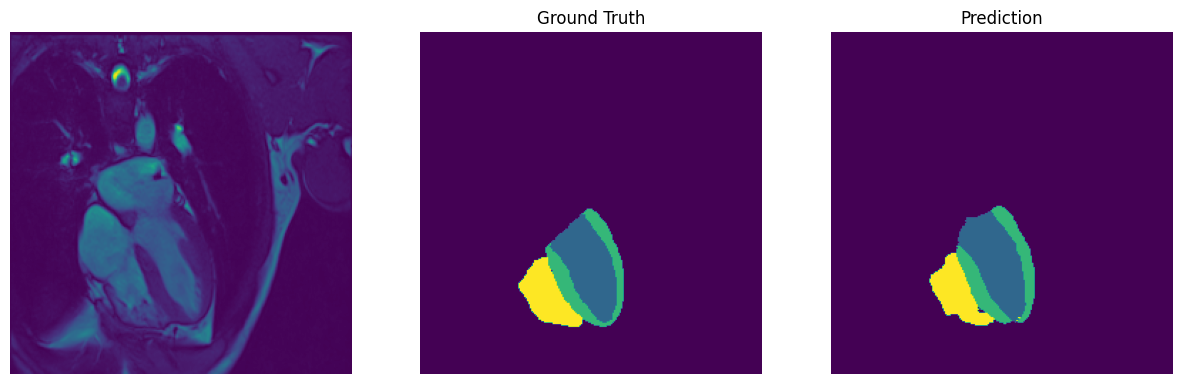

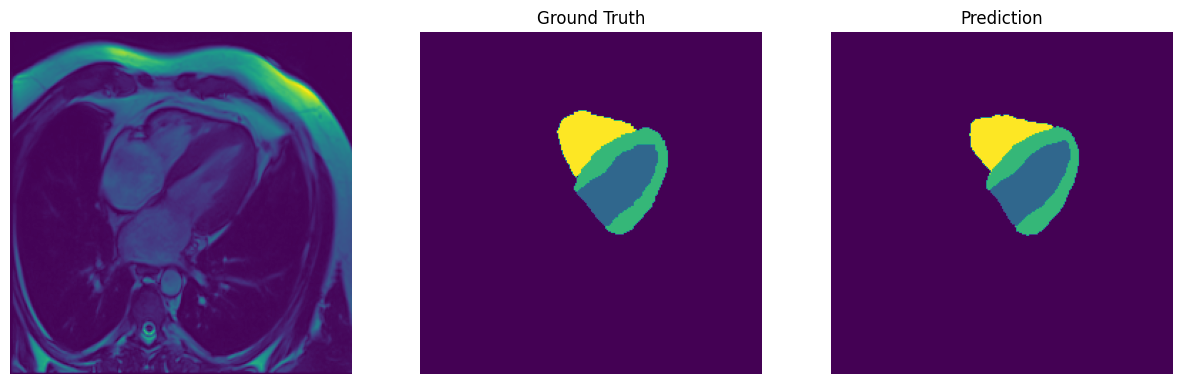

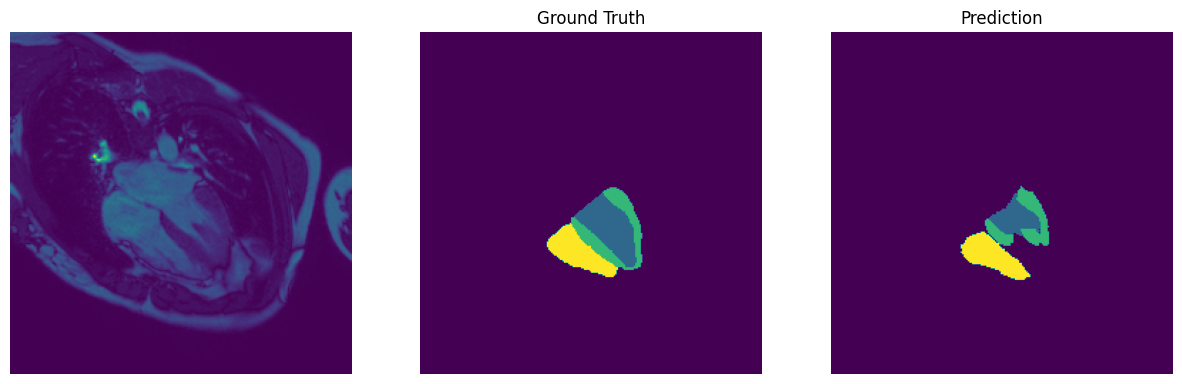

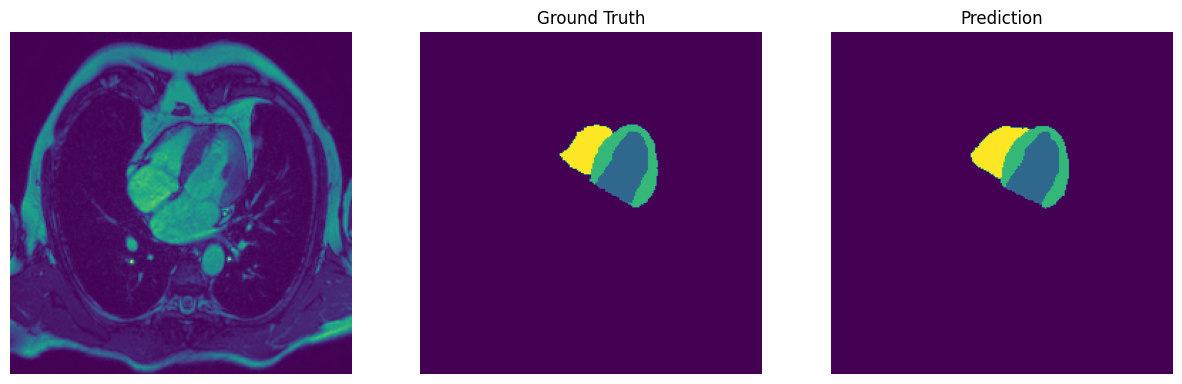

In [ ]:
inputs, classes = next(iter(test_loader))
predict_img(model,inputs, classes,device)

In [ ]:
# checkpoint = UNet(n_channels=1, n_classes=4, bilinear=False).to(device=device)
# PATH = '/content/drive/MyDrive/Final-Year-Project/Final-Model/Vanila-Unet-1024/cosine-anneling-checkpoint.pt'
# checkpoint.load_state_dict(torch.load(PATH))
# checkpoint.eval()

In [ ]:
# evaluation_hd(checkpoint, test_loader, device)

47.339914321899414

In [ ]:
# evaluate(checkpoint,test_loader,device)

tensor(0.8600, device='cuda:0')